In [2]:
import os
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import imageio
import pickle

from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers import Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback
from keras.optimizers import Adam

import tensorflow as tf

Using TensorFlow backend.


# Preparation

Like the previous notebook, function will be placed on TOP to ease loading

In [4]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [20]:
def resize_to_original(img, target_size):
    current_height, current_width = img.shape
    target_height, target_width = target_size
    if current_height >= target_height and current_width >= target_width:
        # we are in case where we expanded with black
        return img[:target_height, :target_width]
    else:
        scale = max(target_height, target_width) / 512
        scaled_image = cv2.resize(img, None, fx=scale, fy=scale, interpolation = cv2.INTER_NEAREST)
        return scaled_image[:target_height, :target_width]
    return img

def compute_IoU(pred, mask, trigger=0.999):
    pred = (pred>trigger)
    mask = (mask>0.9)
    union = np.logical_or(pred, mask)
    intersection = np.logical_and(pred, mask)
    return intersection.sum()/union.sum()

In [6]:
# def mean_iou(y_true, y_pred):
#     prec = []
#     for t in np.arange(0.5, 1.0, 0.05):
#         y_pred_ = tf.to_int32(y_pred > t)
#         score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
#         K.get_session().run(tf.local_variables_initializer())
#         with tf.control_dependencies([up_opt]):
#             score = tf.identity(score)
#         prec.append(score)
#     return K.mean(K.stack(prec), axis=0)

In [7]:
# def mean_iou2(y_true, y_pred):
#     y_pred_ = tf.to_int32(y_pred > 0.5)
#     score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
#     K.get_session().run(tf.local_variables_initializer())
#     with tf.control_dependencies([up_opt]):
#         score = tf.identity(score)
#     return score

We can now load our datas prepared previously. This include matrice of dimensions, images boosted, and masks resized to proper dimensions.

In [8]:
# data = np.load('datas/dataset_RGB.npz')
# IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 512, 512, 3

dimensions = np.array(load_obj("datas/dimensions"))
data = np.load('datas/dataset.npz')
X_train, X_test, y_train, y_test, dim_train, dim_test = train_test_split(data["X"], data["y"], dimensions, test_size=0.1, random_state=42)

In [9]:
print(X_train.shape, " - ", y_train.shape, " - ", X_train.dtype)
print(X_test.shape, " - ", y_test.shape, " - ", X_test.dtype)
print(dim_train.shape, " - ", dim_test.shape, " - ", dim_train.dtype)

(603, 512, 512, 1)  -  (603, 512, 512, 1)  -  uint8
(67, 512, 512, 1)  -  (67, 512, 512, 1)  -  uint8
(603, 2)  -  (67, 2)  -  int32


In [10]:
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = X_train.shape[1:] # 512, 512, 1
BATCH_SIZE = 5
NB_IMAGES_TRAIN = X_train.shape[0]
NB_IMAGES_TEST = X_test.shape[0]
EPOCHS = 30

# Model U-Net 

Thanks to <a href="https://www.kaggle.com/lscoelho/keras-u-net-lb-0-277-epochs-vsplit-thr">this Kernel</a>, I discovered the model presented on <a href="https://arxiv.org/pdf/1505.04597.pdf">arxiv</a>. Originally, I wanted to try to original version but in order to have the same output as input, I changed the padding and the input size to 512x512 to not have issue of round dimensions down.

In [5]:
# IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 572, 572, 1
# padding = "valid"

# inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
# s = Lambda(lambda x: x / 255) (inputs)

# c1 = Conv2D(64, (3, 3), activation='relu', padding=padding) (s)   # 570 x 570
# c1 = Conv2D(64, (3, 3), activation='relu', padding=padding) (c1)  # 568 x 568
# d1 = Cropping2D(cropping=(88))                              (c1)  # 568 -> 392
# p1 = MaxPooling2D((2, 2)) (c1)                                    # 284 x 284

# c2 = Conv2D(128, (3, 3), activation='relu', padding=padding) (p1)  # 282 x 282
# c2 = Conv2D(128, (3, 3), activation='relu', padding=padding) (c2)  # 280 x 280
# d2 = Cropping2D(cropping=(40))                               (c2)  # 280 -> 200
# p2 = MaxPooling2D((2, 2)) (c2)                                     # 140 x 140           

# c3 = Conv2D(256, (3, 3), activation='relu', padding=padding) (p2)  # 138 x 138
# c3 = Conv2D(256, (3, 3), activation='relu', padding=padding) (c3)  # 136 x 136
# d3 = Cropping2D(cropping=(16))                               (c3)  # 136 -> 104 
# p3 = MaxPooling2D((2, 2)) (c3)                                     # 68 x 68

# c4 = Conv2D(512, (3, 3), activation='relu', padding=padding) (p3)  # 66 x 66
# c4 = Conv2D(512, (3, 3), activation='relu', padding=padding) (c4)  # 64 x 64
# d4 = Cropping2D(cropping=(4))                                (c4)  # 64 -> 56 (64-56)/2
# p4 = MaxPooling2D(pool_size=(2, 2)) (c4)                           # 32 x 32

# c5 = Conv2D(1024, (3, 3), activation='relu', padding=padding) (p4)  # 30 x 30
# c5 = Conv2D(1024, (3, 3), activation='relu', padding=padding) (c5)  # 28 x 28

# u6 = Conv2DTranspose(1024, (2, 2), strides=(2, 2), padding=padding) (c5) # 56 x 56
# u6 = concatenate([u6, d4])
# c6 = Conv2D(512, (3, 3), activation='relu', padding=padding) (u6)   # 54 x 54
# c6 = Conv2D(512, (3, 3), activation='relu', padding=padding) (c6)   # 52 x 52

# u7 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding=padding) (c6)  # 104 x 104
# u7 = concatenate([u7, d3])
# c7 = Conv2D(256, (3, 3), activation='relu', padding=padding) (u7)   # 102 x 102
# c7 = Conv2D(256, (3, 3), activation='relu', padding=padding) (c7)   # 100 x 100

# u8 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding=padding) (c7)  # 200 x 200
# u8 = concatenate([u8, d2])
# c8 = Conv2D(128, (3, 3), activation='relu', padding=padding) (u8)   # 198 x 198
# c8 = Conv2D(128, (3, 3), activation='relu', padding=padding) (c8)   # 196 x 196

# u9 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding=padding) (c8)  # 392 x 392
# u9 = concatenate([u9, d1], axis=3)
# c9 = Conv2D(64, (3, 3), activation='relu', padding=padding) (u9)   # 390 x 390
# c9 = Conv2D(64, (3, 3), activation='relu', padding=padding) (c9)   # 388 x 388
# c9 = Conv2D(2, (3, 3), activation='relu', padding="valid") (c9)    # 388 x 388

# outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

# model = Model(inputs=[inputs], outputs=[outputs])

In [6]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
# s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 8)  80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 8)  0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

We will now prepare generators to avoid overfitting. At the same time, it will convert our matrices from uint8 to float 32 per batch.

In [7]:
# https://keras.io/preprocessing/image/ : mask is explain at the bottom

seed = 1

data_gen_args_train = {
    "rotation_range" : 90.,
    "width_shift_range" : 0.1,
    "height_shift_range" : 0.1,
    "zoom_range" : 0.2,
    "shear_range" : 0.2,
    "fill_mode" : "constant",
    "cval" : 0,
    "horizontal_flip" : True,
    "vertical_flip" : True,
    "data_format" : "channels_last",
    "rescale" : 1./255                      # convert uint8 to float32
}

data_gen_args_test = {
    "horizontal_flip" : True,
    "vertical_flip" : True,
    "data_format" : "channels_last",
    "rescale" : 1./255                      # convert uint8 to float32
}

# Creation of image data augmenter for train set
image_datagen_train = ImageDataGenerator(**data_gen_args_train)
mask_datagen_train = ImageDataGenerator(**data_gen_args_train)

# fit this generator to train images
image_datagen_train.fit(X_train, augment=True, seed=seed)
mask_datagen_train.fit(y_train, augment=True, seed=seed)

# create a generator of train images augmented
image_generator_train = image_datagen_train.flow(X_train, batch_size=BATCH_SIZE, seed=seed)
mask_generator_train = mask_datagen_train.flow(y_train, batch_size=BATCH_SIZE, seed=seed)

# Creation of data augmenter for test set
image_datagen_test = ImageDataGenerator(**data_gen_args_test)
mask_datagen_test = ImageDataGenerator(**data_gen_args_test)

# fit this generator to test images
image_datagen_test.fit(X_test, augment=True, seed=seed)
mask_datagen_test.fit(y_test, augment=True, seed=seed)

# create a generator of test images augmented
image_generator_test = image_datagen_test.flow(X_test, batch_size=BATCH_SIZE, seed=seed)
mask_generator_test = mask_datagen_test.flow(y_test, batch_size=BATCH_SIZE, seed=seed)

# zip to output the X_batch a y_batch
train_generator = zip(image_generator_train, mask_generator_train)
test_generator = zip(image_generator_test, mask_generator_test)

In order to see the training, after every epoch, we will save the prediction on few fixed images from test set. This will be handled with the following callback

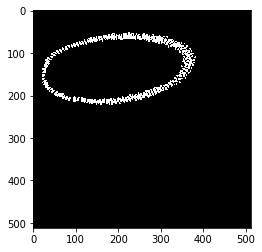

In [13]:
class prediction_history(Callback):
    def __init__(self):
        self.img_id = [8, 11, 12, 24]
        self.epoch = 0
        for idx in self.img_id:
            self.generate_image(X_test[idx, :, : , 0], "Init", idx)
            self.generate_image(y_test[idx, :, : , 0], "Mask", idx)
        
    def on_epoch_end(self, epoch, logs={}):
        self.epoch += 1
        for idx in self.img_id:
            y_pred = model.predict(np.expand_dims(X_test[idx], 0))
            self.generate_image(y_pred[0, :, : , 0], "Epoch", idx)
        
    def generate_image(self, img, name="Epoch", index=0):
        plt.imshow(img.astype(np.float64), cmap='gray')
        plt.title("Epoch {}".format(self.epoch))
        plt.savefig("img/training/{}{}-img{}.png".format(name, self.epoch, index))
        
    def on_train_end(self):
        images = []
        for index in self.img_id:
            for i in range(1, self.epoch):
                images.append(imageio.imread("img/training/Epoch{}-img{}.png".format(i, index)))
            output_file = 'img/training-{}.gif'.format(index)
            imageio.mimsave(output_file, images, duration=0.5)
        
predictions=prediction_history()

Now we have everything to fit the model after compiling it.

In [14]:
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['binary_crossentropy'])

In [24]:
model.fit_generator(generator = train_generator, 
                    steps_per_epoch = NB_IMAGES_TRAIN//BATCH_SIZE, 
                    epochs=EPOCHS, 
                    validation_data=test_generator,
                    validation_steps = NB_IMAGES_TEST//BATCH_SIZE, 
                    callbacks = [predictions]
                   )

model.save("models/model.h5")

In [9]:
# X_train = data["X"].astype(np.float16)/255
# y_train = data["y"].astype(np.float16)/255

# model.fit(
#     x=X_train, 
#     y=y_train, 
#     batch_size=10, 
#     epochs=3, 
# #     verbose=0, 
#     validation_split=0.1, 
#     shuffle=True)

Train on 603 samples, validate on 67 samples
Epoch 1/3
603/603 [==============================] - 40s 66ms/step - loss: 0.6525 - binary_crossentropy: 0.6525 - val_loss: 0.2907 - val_binary_crossentropy: 0.2907
Epoch 2/3
603/603 [==============================] - 36s 60ms/step - loss: 0.2507 - binary_crossentropy: 0.2507 - val_loss: 0.1739 - val_binary_crossentropy: 0.1739
Epoch 3/3
603/603 [==============================] - 36s 61ms/step - loss: 0.1886 - binary_crossentropy: 0.1886 - val_loss: 0.1263 - val_binary_crossentropy: 0.1263


Let's visualise for few train images the result. Not to evaluate it but to see if model learn (yes I made lot of tries where a mistake made the model not learning :D )

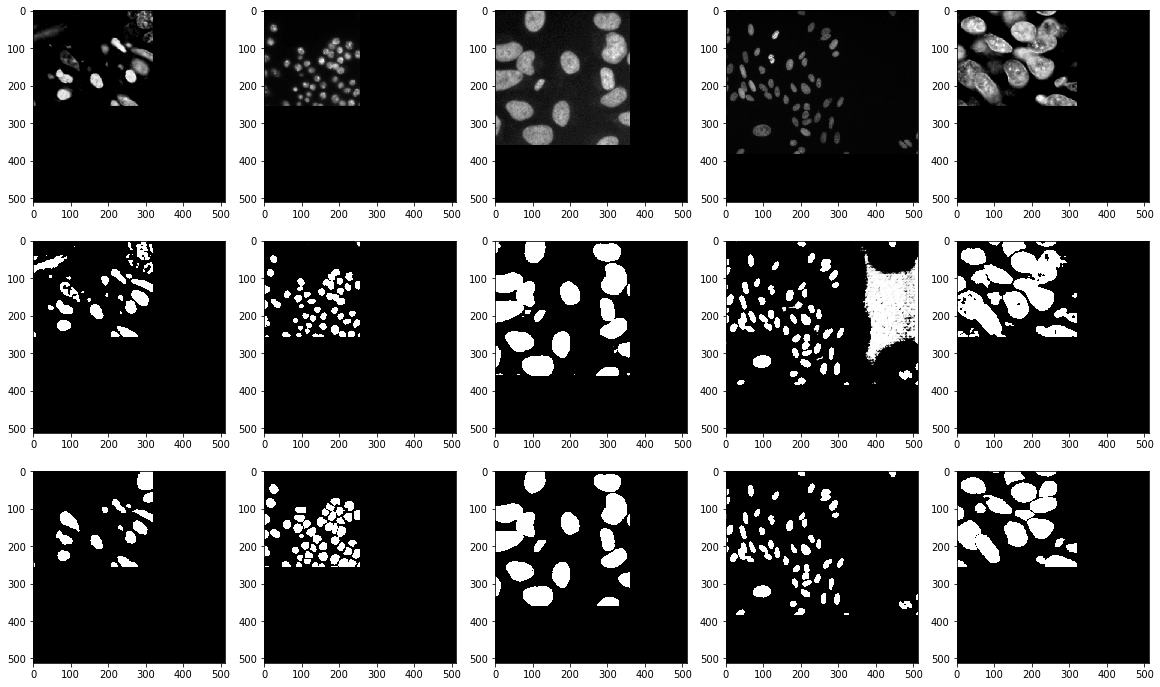

In [23]:
image_list= [10, 25, 152, 200, 255]
f, axarr = plt.subplots(3, len(image_list), figsize=(20,12))
for idx, img_id in enumerate(image_list):
    y_pred = model.predict(np.expand_dims(X_train[img_id], 0))
    axarr[0, idx].imshow(X_train[img_id, :, : , 0].astype(np.float64), cmap='gray')
    axarr[1, idx].imshow(y_pred[0, :, : , 0], cmap='gray')
    axarr[2, idx].imshow(y_train[img_id, :, : , 0].astype(np.float64), cmap='gray')
plt.savefig("img/prediction_train.png")
plt.show()

# Evaluation 

At the end of the training, we save the model. We can now evaluation the IoU on test set images. As our output is a sigmoid, we can also adjust our threashold for black/white pixel to improve IoU.

In [11]:
model = load_model("models/model.h5")

In [22]:
final_score = []
threshold = [0.05 * i for i in range(10, 20)]
for t in threshold:
    score = []
    for idx in range(NB_IMAGES_TEST):
        img = X_test[idx, :, : , :]
        pred = model.predict(np.expand_dims(img, 0))[0, :, : , 0]
        mask = y_test[idx, :, : , 0]
        dims = dim_test[idx].tolist()

        mask = resize_to_original(mask, dims)
        pred = resize_to_original(pred, dims)

        IOU = compute_IoU(pred, mask, trigger=0.9999)
        if IOU >= t:
            score.append(1)
        else:
            score.append(0)
    final_score.append(sum(score)/len(score))
    print("Score (with threshold = {:.2f}) = {:.3f}".format(t, sum(score)/len(score)))
print("Final score = {:.3f}".format(sum(final_score)/len(final_score)))

Score (with threshold = 0.50) = 0.791
Score (with threshold = 0.55) = 0.776
Score (with threshold = 0.60) = 0.731
Score (with threshold = 0.65) = 0.701
Score (with threshold = 0.70) = 0.627
Score (with threshold = 0.75) = 0.522
Score (with threshold = 0.80) = 0.403
Score (with threshold = 0.85) = 0.179
Score (with threshold = 0.90) = 0.104
Score (with threshold = 0.95) = 0.000
Final score = 0.484


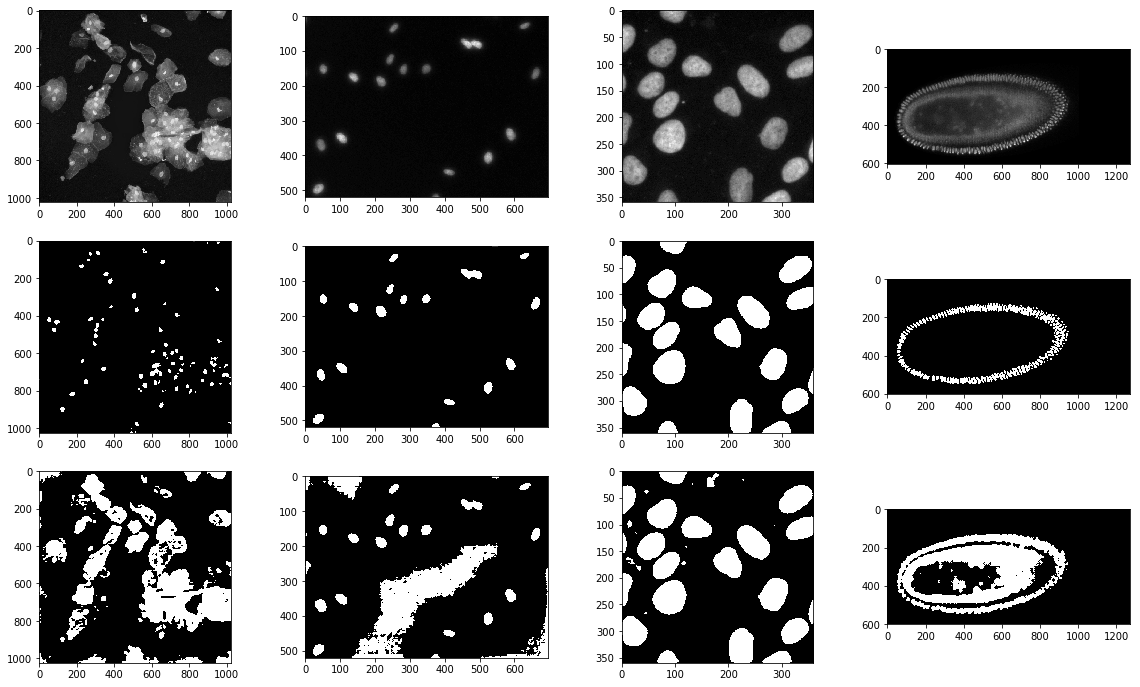

In [57]:
best_t = 0.999
image_list= [8, 11, 12, 24]
# f, axarr = plt.subplots(5, len(image_list), figsize=(20,20))
f, axarr = plt.subplots(3, len(image_list), figsize=(20,12))
for idx, img_id in enumerate(image_list):
    image = X_test[img_id, :, : , :].astype(np.float32)
    mask = y_test[img_id, :, : , :].astype(np.float32)
    y_pred = model.predict(np.expand_dims(image, 0))[0, :, : , 0]
    
    dims = dim_test[img_id].tolist()
    
    img_2 = resize_to_original(image[:, :, 0], dims)
    mask_2 = resize_to_original(mask[:, :, 0], dims)
    pred_2 = resize_to_original(y_pred, dims)
    
    axarr[0, idx].imshow(img_2, cmap='gray')   
#     axarr[1, idx].imshow(mask[:, : , 0], cmap='gray')
#     axarr[2, idx].imshow(y_pred>0.9, cmap='gray')
#     axarr[3, idx].imshow(mask_2, cmap='gray')
#     axarr[4, idx].imshow(pred_2, cmap='gray')

    axarr[1, idx].imshow(mask_2, cmap='gray')
    axarr[2, idx].imshow(pred_2>best_t, cmap='gray')
plt.savefig("img/prediction_test.png")
plt.show()

The prediction for Kaggle will be handled in another Notebook with only required points compiled.